# Candidate Test 2022 Analysis Part 1

This exercise focuses on the candidate tests from two television networks: DR and TV2. Data from both tests have been given on a scale of five responses (-2, -1, 0, 1, 2).

---

There are 6 datasets included in this exercise:

- `alldata.xlsx`: Contains responses from both TV stations.
- `drdata.xlsx`: Contains responses from DR.
- `drq.xlsx`: Contains questions from DR.
- `tv2data.xlsx`: Contains responses from TV2.
- `tv2q.xlsx`: Contains questions from TV2.
- `electeddata.xlsx`: Contains responses from both TV stations for candidates who were elected to the parliament. Note that 9 members are missing; 7 of them didn't take any of the tests. Additionally, some notable figures like Mette F. and Lars Løkke did not participate in any of the tests.

---

It's entirely up to you how you approach this data, but at a *minimum*, your analysis should include:
- Age of the candidates grouped by parties.
- An overview of the most "confident" candidates, i.e., those with the highest proportion of "strongly agree" or "strongly disagree" responses.
- Differences in responses between candidates, both inter-party and intra-party, along with an explanation of which parties have the most internal disagreements.
- Classification models to predict candidates' party affiliations. Investigate if there are any candidates who seem to be in the "wrong" party based on their political landscape positions. You must use the following three algorithms: **Decision Tree, Random Forrest, and Gradient Boosted Tree**, and **two other** classification algorithms of your choice.

---

The following parties are represented:

| Party letter | Party name | Party name (English) | Political position |
| :-: | :-: | :-: | :-: |
| A | Socialdemokratiet | Social Democrats | Centre-left |
| V | Venstre | Danish Liberal Party | Centre-right |
| M | Moderaterne | Moderates | Centre-right |
| F | Socialistisk Folkeparti | Socialist People's Party | Left-wing |
| D | Danmarksdemokraterne | Denmark Democrats | Right-wing |
| I | Liberal Alliance | Liberal Alliance | Right-wing |
| C | Konservative | Conservative People's Party | Right-wing |
| Æ | Enhedslisten | Red-Green Alliance | Far-left |
| B | Radikale Venstre | Social Liberal Party | Centre-left |
| D | Nye Borgerlige | New Right | Far-right |
| Z | Alternativet | The Alternative | Centre-left |
| O | Dansk Folkeparti | Danish People's Party | Far-right |
| G | Frie Grønne | Free Greens | Centre-left |
| K | Kristendemokraterne | Christian Democrats | Centre-right |

Below you can see the results and the colors chosen to represent the parties. Use these colors in your analysis above.

![Alt text](image-1.png)


Others have undertaken similar analyses. You can draw inspiration from the following (use Google tranlsate if your Danish is rusty):

- [Analysis of where individual candidates stand relative to each other and their parties](https://v2022.dumdata.dk/)
- [Candidate Test 2022 – A deep dive into the data](https://kwedel.github.io/kandidattest2022/)
- [The Political Landscape 2019](https://kwedel.github.io/kandidattest2019/)



## Data preparation
In this section we are preparing the data to be worked on.
But also cleaning up some of the names of columns and the sorting, which should help to make the data more readable.

In [39]:
import pandas as pd
import sklearn as sk

# Utility function - Rename the columns to be more descriptive
def rename_columns(data : pd.DataFrame) -> pd.DataFrame:
    # ? Renaming the columns for the TV2 answers.
    # So the names are easier to understand and work with.
    tv2_original_columns = ['1a','1b','2a','2b','3a','3b','4a','4b',
                            '5a','5b','6a','6b','7a','7b','8a','8b',
                            '9a','9b','10a','10b','11a','11b','12a','12b']
    tv2_new_columns = ['TV2-1a','TV2-1b','TV2-2a','TV2-2b','TV2-3a','TV2-3b','TV2-4a','TV2-4b',
                       'TV2-5a','TV2-5b','TV2-6a','TV2-6b','TV2-7a','TV2-7b','TV2-8a','TV2-8b',
                       'TV2-9a','TV2-9b','TV2-10a','TV2-10b','TV2-11a','TV2-11b','TV2-12a','TV2-12b']
    
    # ? Renaming the columns for the DR answers.
    # So the names are easier to understand and work with.
    dr_orignal_columns = ['530','531','533','534','535','537','538','540','541','543','544','545','546','547','548',
                          '550','551','552','553','555','556','557','559','561','563']
    
    dr_new_columns =  ['DR-1','DR-2','DR-3','DR-4','DR-5','DR-6','DR-7','DR-8','DR-9','DR-10','DR-11','DR-12','DR-13','DR-14','DR-15',
                       'DR-16','DR-17','DR-18','DR-19','DR-20','DR-21','DR-22','DR-23','DR-24','DR-25']

    other_columns_original = ['navn','alder','parti','storkreds']
    other_columns_new = ['Name','Age','Party','District']

    # ! Renaming the actual columns
    data.rename(columns=dict(zip(tv2_original_columns, tv2_new_columns)), inplace=True)
    data.rename(columns=dict(zip(dr_orignal_columns, dr_new_columns)), inplace=True)
    data.rename(columns=dict(zip(other_columns_original, other_columns_new)), inplace=True)
    return data

# Utility function - Set the column order to be more intuitive
def reorder_columns(data : pd.DataFrame) -> pd.DataFrame:
    # ? Reordering the columns
    # So the columns are easier to understand and work with.
    strict_column_order = ['Name','Age','Party','District'];
    remaining_columns = [col for col in data.columns if col not in strict_column_order]
    data = data[strict_column_order + remaining_columns]
    return data

# - Load the raw data from the file 'alldata.xlsx' into a pandas dataframe.
raw_data = pd.read_excel('alldata.xlsx')

# * Create a DataFrame
raw_dataFrame = pd.DataFrame(raw_data)

# ! Renaming the columns
clean_data = rename_columns(raw_dataFrame)

# ! Reordering the columns
clean_data = reorder_columns(raw_dataFrame)

# ? Cleaning party names
clean_data['Party'] = clean_data['Party'].replace('Frie Grønne, Danmarks Nye Venstrefløjsparti', 'Frie Grønne')


# * Preview the cleaned DataFrame
preview_dataFrame = clean_data.head(5)
preview_dataFrame = preview_dataFrame.style.set_caption('Preview of the cleaned DataFrame.')
preview_dataFrame = preview_dataFrame.set_table_styles([dict(selector='th', props=[('text-align', 'left')])])
preview_dataFrame = preview_dataFrame.set_properties(**{'text-align': 'center'})

display(preview_dataFrame.hide())

Name,Age,Party,District,DR-1,DR-2,DR-3,DR-4,DR-5,DR-6,DR-7,DR-8,DR-9,DR-10,DR-11,DR-12,DR-13,DR-14,DR-15,DR-16,DR-17,DR-18,DR-19,DR-20,DR-21,DR-22,DR-23,DR-24,DR-25,TV2-1a,TV2-1b,TV2-2a,TV2-2b,TV2-3a,TV2-3b,TV2-4a,TV2-4b,TV2-5a,TV2-5b,TV2-6a,TV2-6b,TV2-7a,TV2-7b,TV2-8a,TV2-8b,TV2-9a,TV2-9b,TV2-10a,TV2-10b,TV2-11a,TV2-11b,TV2-12a,TV2-12b
Lars Philipsen Prahm,78,Moderaterne,Københavns Storkreds,-1,-2,1,-2,2,1,-2,1,1,2,-2,1,2,2,1,-2,1,2,-2,2,2,1,2,2,-2,0,0,2,2,2,-2,-1,0,-1,1,-1,1,2,2,1,0,2,0,1,-2,-2,1,1,1
Karsten Hønge,64,Socialistisk Folkeparti,Fyns Storkreds,2,2,-1,-2,-1,-2,1,-2,2,-2,2,-1,-2,-2,2,2,-2,1,1,-1,-2,1,2,1,2,1,1,1,1,1,2,2,2,-2,0,1,-2,-2,0,0,0,-2,0,-1,2,1,-2,0,0
Martin Kelleher-Petersen,37,Alternativet,Bornholms Storkreds,2,1,-2,-2,1,-2,1,-1,1,-1,2,-2,-2,-1,1,1,-2,2,-1,-2,-1,1,2,2,2,1,1,1,2,1,1,2,0,-1,1,2,-2,-2,-2,1,1,-1,-2,0,2,0,-1,1,-2
Nicklas Gjedsig Larsen,28,Alternativet,Nordjyllands Storkreds,2,1,-2,-1,1,1,1,1,1,-2,2,1,1,-2,2,2,-2,2,1,2,-2,2,2,2,2,2,2,2,2,0,2,0,2,-2,2,-1,2,0,-2,2,2,-2,2,2,2,2,-1,2,0
Tom Gillesberg,58,Løsgænger,Københavns Storkreds,1,1,-2,2,-2,1,-2,1,2,-2,-2,2,2,-2,2,1,-2,2,-2,-2,-1,1,-2,-1,-2,-2,-2,0,0,-2,-2,2,1,-2,2,1,-2,2,-2,1,0,-2,0,-1,0,-2,0,2,-2


## Age distribution with the different parties

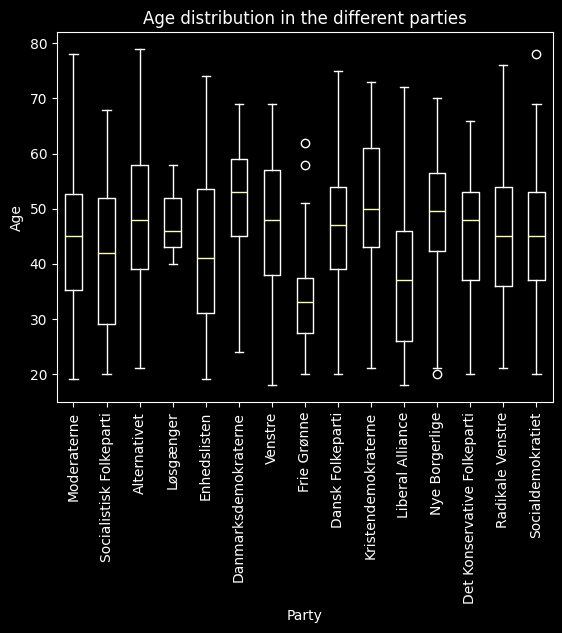

In [13]:
import matplotlib.pyplot as plot

filtered_data = clean_data[clean_data['Age'] != 0]

# - Fetch the necessary data 
ages = filtered_data['Age']
parties = filtered_data['Party']

# * Initialize the empty dictionary
party_ages = {}

# * Iterate through the data and populate the dictionary
for index, row in filtered_data.iterrows():
    party = row['Party']
    age = row['Age']
    if party in party_ages:
        party_ages[party].append(age)
    else:
        party_ages[party] = [age]


# * Extract the data from the dictionary
party_names = list(party_ages.keys())
party_ages = list(party_ages.values())

# * Plot the data
plot.boxplot(party_ages, labels=party_names)

# ? Style the plot
plot.style.use('dark_background')
plot.xticks(range(1, len(party_names) + 1), party_names, rotation=90)
plot.title('Age distribution in the different parties')
plot.xlabel('Party')
plot.ylabel('Age')

# - Display the plot
plot.show()


## Overview on the most "Confident" candiates
*I.E - Those with the highest proportion of "strongly agree" or "strongly disagree"*

Firstly we are going to gain all the insight on the different candicates answer distribution.
Afterwards we are going to look for the last distribution with in the 'Strongly Agree' and 'Strongly Disagree' columns

In [4]:

# - Fetch the necessary data
selected_data = clean_data[['Name', 'Party'] + [col for col in clean_data.columns if 'DR' in col or 'TV2' in col]]
responses = [col for col in selected_data.columns if 'DR' in col or 'TV2' in col]

# * Initialize the empty dictionary
candidate_answers = {}

# ! Iterate through the data and populate the dictionary
for index, row in selected_data.iterrows():
    # * Extract the candidate's name

    # * Initialize the empty dictionary
    candidate_answers[index] = {
        'Name' : row['Name'],
        'Party' : row['Party'],
        'Strongly Agree': 0,
        'Agree': 0,
        'Neutral': 0,
        'Disagree': 0,
        'Strongly Disagree': 0,
    }

    # ! Iterate through the answers and populate the dictionary
    for response in responses:
        # * Extract the response
        value = row[response]

        # ? Update the dictionary based on the response
        if value == 2:
            candidate_answers[index]['Strongly Agree'] += 1
        elif value == 1:
            candidate_answers[index]['Agree'] += 1
        elif value == 0:
            candidate_answers[index]['Neutral'] += 1
        elif value == -1:
            candidate_answers[index]['Disagree'] += 1
        elif value == -2:
            candidate_answers[index]['Strongly Disagree'] += 1

# - Make a DataFrame from the dictionary
candidate_answers = pd.DataFrame(candidate_answers).T

# * Convert the counts to numeric for counts
candidate_answers['Strongly Agree'] = pd.to_numeric(candidate_answers['Strongly Agree'])
candidate_answers['Agree'] = pd.to_numeric(candidate_answers['Agree'])
candidate_answers['Neutral'] = pd.to_numeric(candidate_answers['Neutral'])
candidate_answers['Disagree'] = pd.to_numeric(candidate_answers['Disagree'])
candidate_answers['Strongly Disagree'] = pd.to_numeric(candidate_answers['Strongly Disagree'])

# ? Style the DataFrame
preview_answers = candidate_answers.head(10).style.set_caption('Preview of the candidate answers.')
preview_answers = preview_answers.set_table_styles([dict(selector='th', props=[('text-align', 'left')])])
preview_answers = preview_answers.set_properties(**{'text-align': 'center'})

# * Preview the DataFrame
display(preview_answers.hide())




Name,Party,Strongly Agree,Agree,Neutral,Disagree,Strongly Disagree
Lars Philipsen Prahm,Moderaterne,15,15,5,4,10
Karsten Hønge,Socialistisk Folkeparti,12,12,7,5,13
Martin Kelleher-Petersen,Alternativet,10,16,3,8,12
Nicklas Gjedsig Larsen,Alternativet,25,9,4,3,8
Tom Gillesberg,Løsgænger,10,9,6,3,21
Jan Kristoffersen,Alternativet,10,15,4,14,6
Johan Kahl,Moderaterne,12,17,3,11,6
Thor Clasen Jonasen,Alternativet,17,10,1,10,11
Chresten H. Ibsen,Løsgænger,11,14,5,13,6
Vinni Kjærgaard Jørgensen,Alternativet,12,12,7,3,15


### Top 5 - Candidates with the most strongly combined answers

In [5]:
# # Top 5 strongly combined

# * Create a copy of the DataFrame
# So we can modify it without affecting the original
modified_candidate_answers = candidate_answers.copy()

# * Add a new column to the DataFrame
# That contains the sum of the 'Strongly Agree' and 'Strongly Disagree' columns
modified_candidate_answers['Strongly Combined'] = modified_candidate_answers['Strongly Agree'] + modified_candidate_answers['Strongly Disagree']

# * Sort the DataFrame by the new column in descending order
# And only display the top 5
top_5_strongly_combined = modified_candidate_answers.sort_values('Strongly Combined', ascending=False).head(5)

# ? Style the DataFrame
top_5_strongly_combined = top_5_strongly_combined.style.set_caption('Top 5 candidates with the most strongly combined answers.')
top_5_strongly_combined = top_5_strongly_combined.set_table_styles([dict(selector='th', props=[('text-align', 'left')])])
top_5_strongly_combined = top_5_strongly_combined.set_properties(**{'text-align': 'center'})

# - Display the DataFrame
display(top_5_strongly_combined.hide())

Name,Party,Strongly Agree,Agree,Neutral,Disagree,Strongly Disagree,Strongly Combined
Sarah Nørris,Enhedslisten,24,0,0,0,25,49
Søren Vanting,Det Konservative Folkeparti,18,0,0,0,31,49
Kim Andkjær Doberck,Nye Borgerlige,22,0,4,1,22,44
Rashid Ali,Frie Grønne,23,3,2,1,20,43
Mohamed Abdikarim,Frie Grønne,21,1,0,5,22,43


### Top 5 - Candidates with the most strongly disagree answers

In [6]:

# # Top 5 strongly agree

# * Sort the DataFrame by the 'Strongly Agree' column in descending order
# And only display the top 5
top_5_strongly_agree = candidate_answers.sort_values(by='Strongly Agree', ascending=False).head(5)

# ? Style the DataFrame
top_5_strongly_agree = top_5_strongly_agree.style.set_caption('Top 5 candidates with the most strongly agree answers.')
top_5_strongly_agree = top_5_strongly_agree.set_table_styles([dict(selector='th', props=[('text-align', 'left')])])
top_5_strongly_agree = top_5_strongly_agree.set_properties(**{'text-align': 'center'})

# - Display the DataFrame
display(top_5_strongly_agree.hide())

Name,Party,Strongly Agree,Agree,Neutral,Disagree,Strongly Disagree
Jesper Callesen,Alternativet,25,6,2,6,10
Frank Sørensen,Dansk Folkeparti,25,4,0,3,17
Nicklas Gjedsig Larsen,Alternativet,25,9,4,3,8
Sarah Nørris,Enhedslisten,24,0,0,0,25
Jef Seistrup,Alternativet,24,4,3,2,16


### Top 5 - Candidates with the most strongly agree answers

In [7]:

# # Top 5 strongly disagree

# * Sort the DataFrame by the 'Strongly Disagree' column in descending order
# And only display the top 5
top_5_strongly_disagree = candidate_answers.nlargest(5, 'Strongly Disagree', keep='all')

# ? Style the DataFrame
top_5_strongly_disagree = top_5_strongly_disagree.style.set_caption('Top 5 candidates with the most strongly combined answers.')
top_5_strongly_disagree = top_5_strongly_disagree.set_table_styles([dict(selector='th', props=[('text-align', 'left')])])
top_5_strongly_disagree = top_5_strongly_disagree.set_properties(**{'text-align': 'center'})

# - Display the DataFrame
display(top_5_strongly_disagree.hide())

Name,Party,Strongly Agree,Agree,Neutral,Disagree,Strongly Disagree
Søren Vanting,Det Konservative Folkeparti,18,0,0,0,31
Sarah Nørris,Enhedslisten,24,0,0,0,25
Steffen Sjørslev,Liberal Alliance,15,4,2,3,25
John Bjerg,Nye Borgerlige,18,3,3,1,24
Thomas Vedsted,Nye Borgerlige,17,4,2,2,24


## Differences in responses between candidates
*In this section we are going to be looking at the difference between the average candidate and each candidates answers.*

*We are also going to be looking at the differences with parties*

## Inter-party
In this segment, we're taking a look at how candidates from different parties don't always have the same opionins. It's interesting to see which questions have them split the most and which they can agree on. 

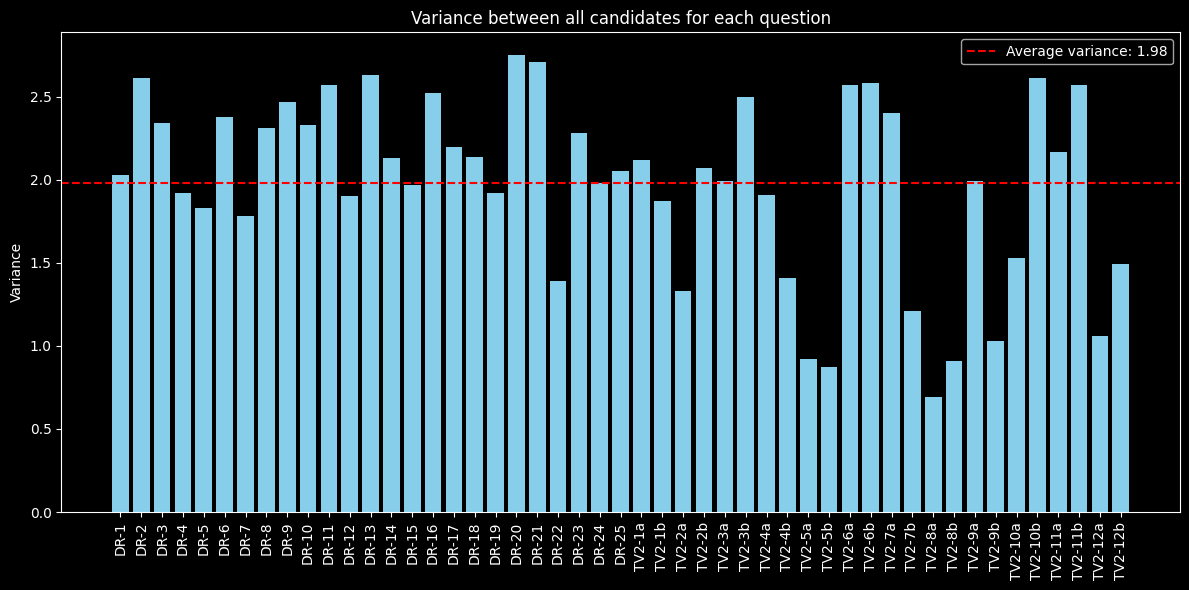

In [15]:
import numpy as np

# - Fetch the necessary data
selected_data = clean_data[['Name', 'Party'] + [col for col in clean_data.columns if 'DR' in col or 'TV2' in col]]

# - Find the questions
responses = [col for col in selected_data.columns if 'DR' in col or 'TV2' in col]

# * Initialize the empty dictionary
data = {}

# ! Iterate through the responses and populate the dictionary
for response in responses:
    # * Calculate the variance for each response
    data[response] = selected_data[response].var()

# - Make a DataFrame from the dictionary
df_var = pd.DataFrame(data , index=[0])

# * Format the variance to be more readable
df_var = df_var.map(lambda x: '{:.2f}'.format(x))

# ? Style the DataFrame
differences_variance = df_var.style.set_caption('Variance of the responses.')
differences_variance = differences_variance.set_table_styles([dict(selector='th', props=[('text-align', 'left')])])
differences_variance = differences_variance.set_properties(**{'text-align': 'center'})

# - Display the DataFrame
# display(differences_variance.hide())

# - Create Bar plot
# Transpose the DataFrame
df_var_transposed = df_var.T

# * Convert the variance values from string to float
df_var_transposed[0] = df_var_transposed[0].astype(float)

# * Generate the bar plot
plot.style.use('dark_background')
plot.figure(figsize=(12, 6))  # Set the figure size as desired
plot.bar(df_var_transposed.index, df_var_transposed[0], color='skyblue')  # Plotting

# * Calculate the average and add a line to the plot
average_variance = df_var_transposed[0].mean()
plot.axhline(y=average_variance, color='r', linestyle='--', label=f'Average variance: {average_variance:.2f}')

# ? Style the plot
plot.title('Variance between all candidates for each question')
plot.xticks(rotation=90, ha="center")
plot.ylabel('Variance')
plot.legend()
plot.tight_layout()

# - Display the plot
plot.show()


The diagram above illustrates the variance in responses to different questions. This variance can be interpreted as a measure of agreement or disagreement among the candidates' answers. Higher variance bars suggest a wider range of opinions among the candidates on those particular questions, for instance, `DR-20`. Conversely, questions with lower variances indicate a relative consensus among the candidates.

## Intra-party
In this segment, we're going to take a look at how the opionins can differ even within the same party. This should give us a general depiction of how the general consensus is within the different parties.

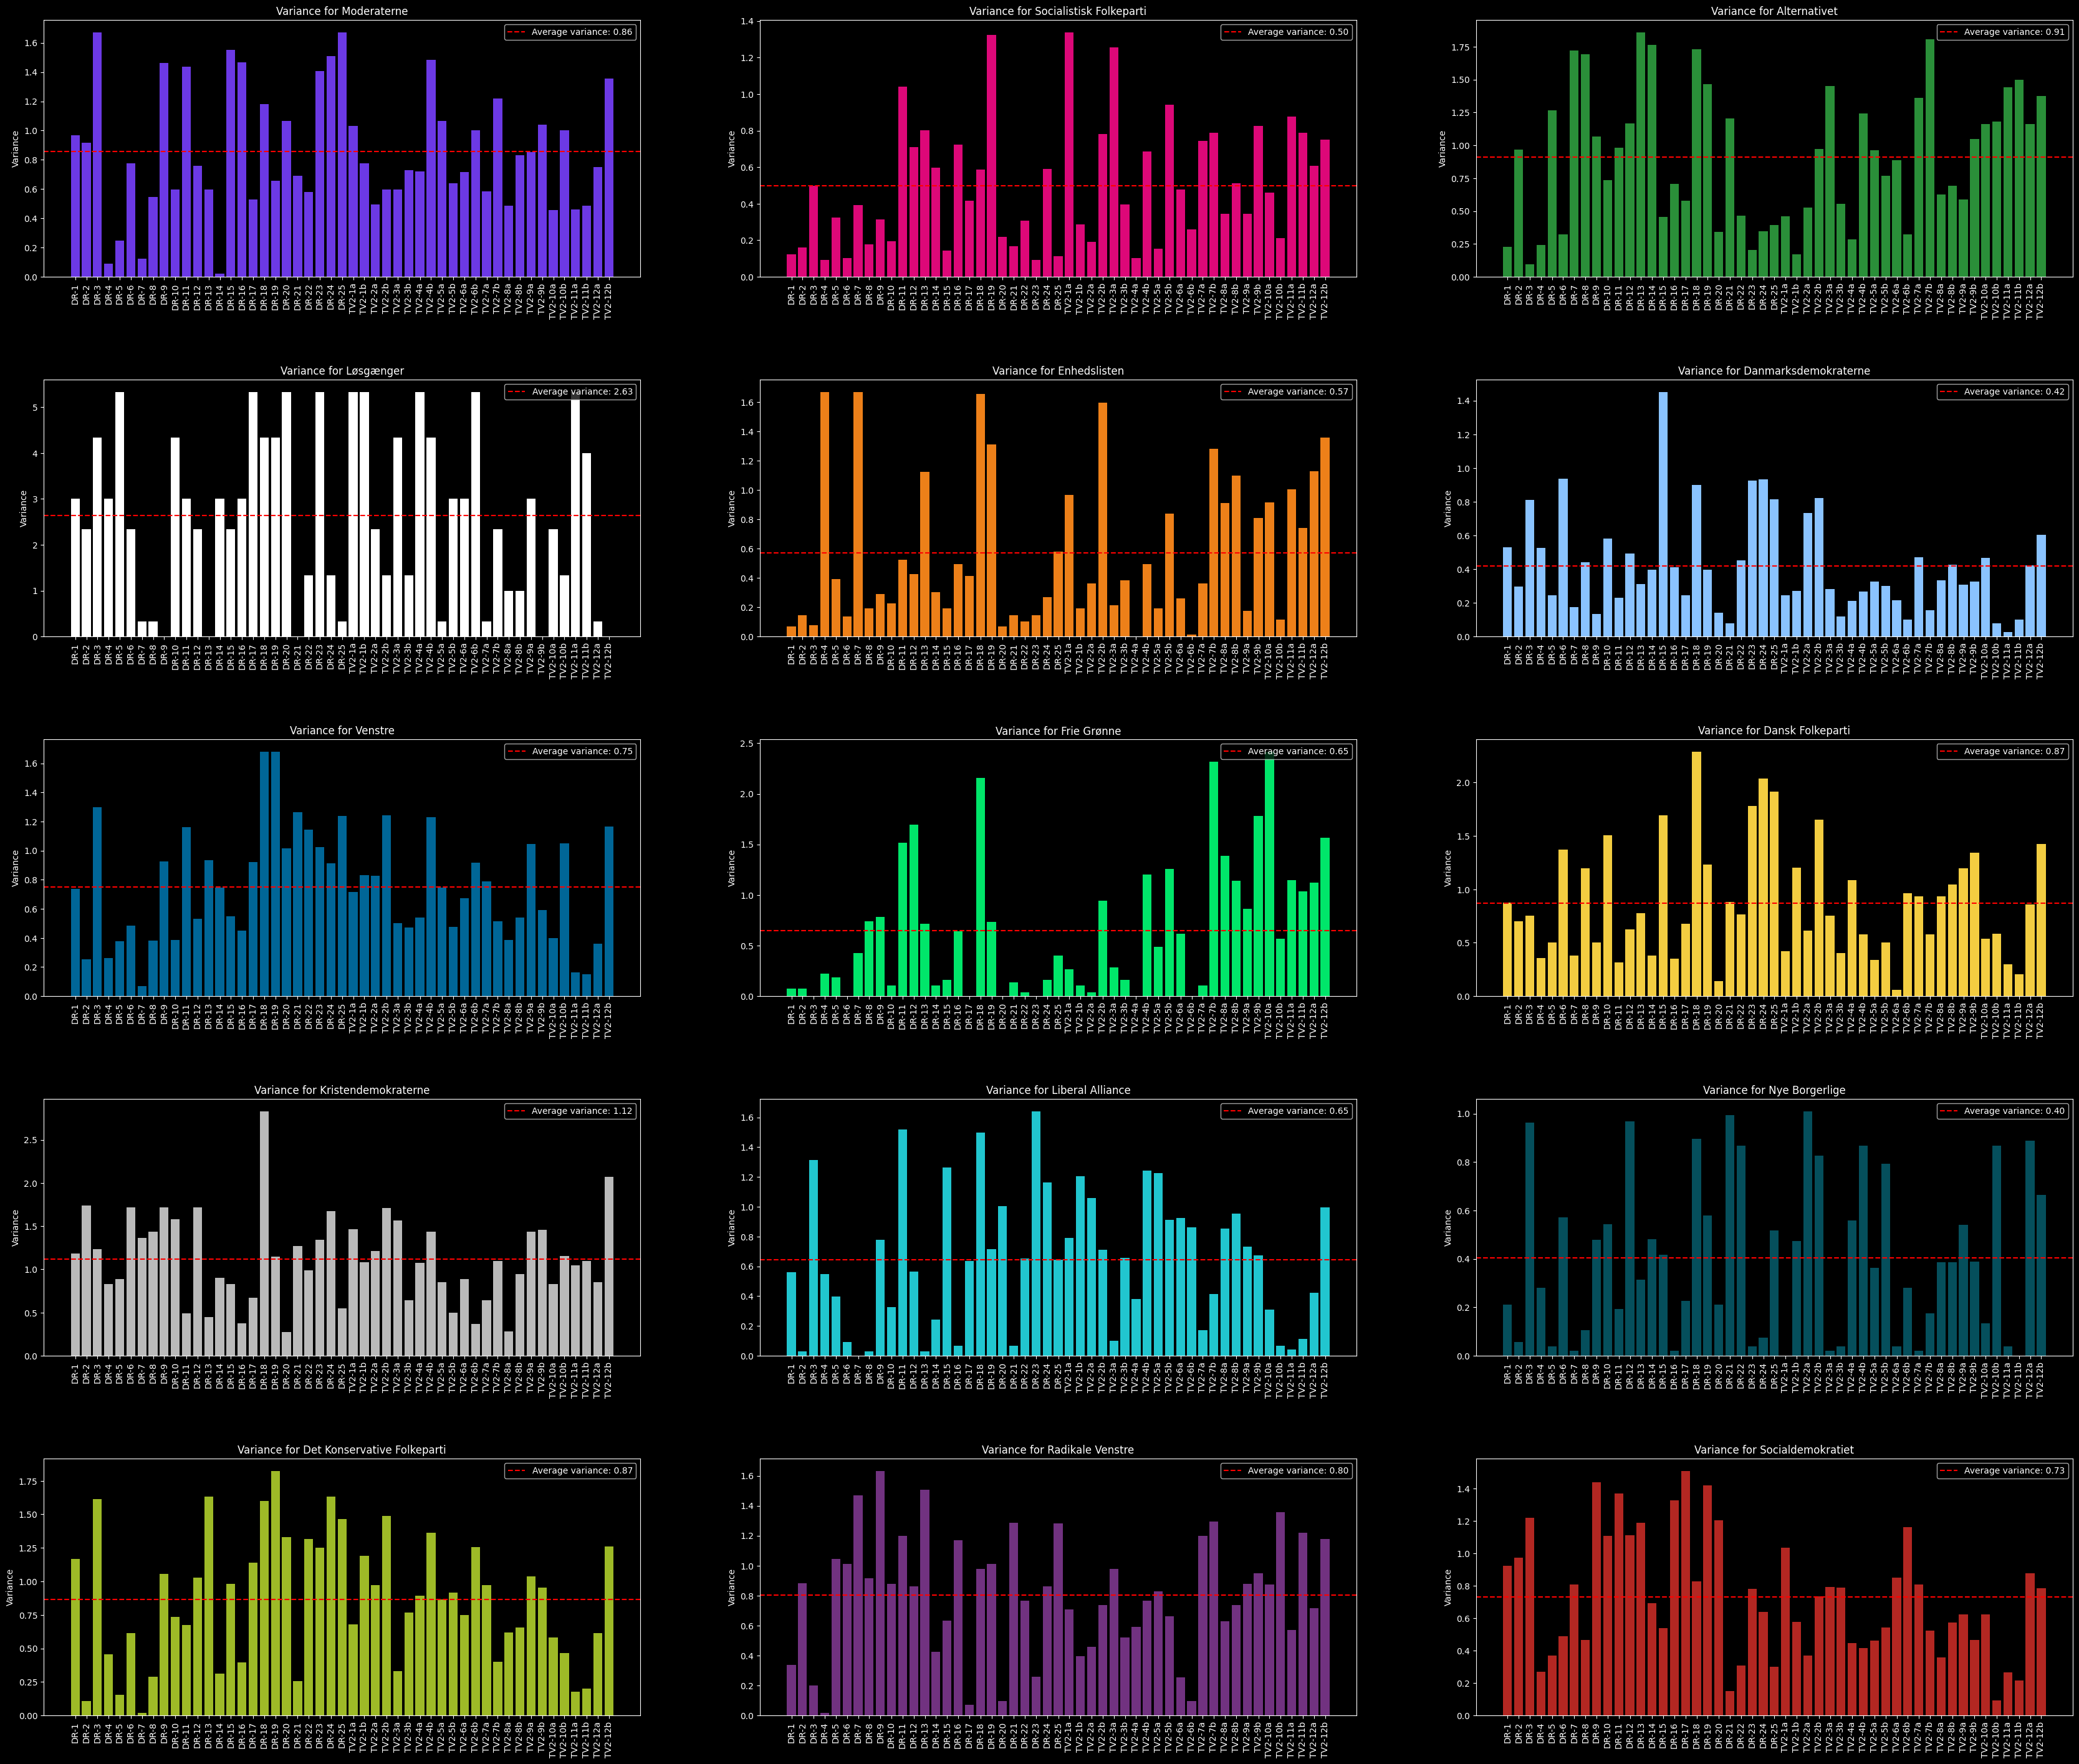

In [68]:
import numpy as np

# Utility function - Colors for the different parties
def party_colors() -> dict:
    return {
        'Moderaterne': '#6c39e5',
        'Socialistisk Folkeparti': '#dd0878',
        'Alternativet': '#2a8f39',
        'Løsgænger': 'white',
        'Enhedslisten': '#ed8019',
        'Danmarksdemokraterne': '#8ac3ff',
        'Venstre': '#006697',
        'Frie Grønne': '#00e66a',
        'Dansk Folkeparti': '#f3cd41',
        'Kristendemokraterne': '#bababa',
        'Liberal Alliance': '#21c6cf',
        'Nye Borgerlige': '#054f5c',
        'Det Konservative Folkeparti': '#9eba27',
        'Radikale Venstre': '#713280',
        'Socialdemokratiet': '#b32722'
    }

# - Fetch the necessary data
selected_data = clean_data[['Name', 'Party'] + [col for col in clean_data.columns if 'DR' in col or 'TV2' in col]]

# - Find the questions
responses = [col for col in selected_data.columns if 'DR' in col or 'TV2' in col]

# - Find the parties
parties = selected_data['Party'].unique()
party_colors = party_colors()

# * Initialize the empty dictionary
data = {}

# ! Iterate through the responses and populate the dictionary
for response in responses:
    # * Calculate the variance for each response
    for party in parties:
        # * Extract the data for the specific party
        party_data = selected_data[selected_data['Party'] == party]

        # * Calculate the variance for the party
        variance = party_data[response].var()

        # ? Update the dictionary
        if party in data:
            data[party][response] = variance
        else:
            data[party] = {response: variance}


# * Calculate the number of rows and columns for the subplots
n_parties = len(parties)
n_cols = 3
n_rows = np.ceil(n_parties / n_cols).astype(int)

# * Create the subplots
plot.style.use('dark_background')
fig, axs = plot.subplots(n_rows, n_cols, figsize=(14 * n_cols, 8 * n_rows))  # Adjust the figure size as needed

# * Flatten the axis array for easy indexing
axs = axs.flatten()

# ? Iterate through the parties and plot the variance
for idx, party in enumerate(parties):
    df_var = pd.DataFrame(data[party], index=[0])
    df_var_transposed = df_var.T
    df_var_transposed[0] = df_var_transposed[0].astype(float)
    
    # * Plot on the respective subplot
    ax = axs[idx]
    ax.bar(df_var_transposed.index, df_var_transposed[0], color=party_colors[party])
    
    # * Calculate the average and add a line to the plot
    average_variance = df_var_transposed[0].mean()
    ax.axhline(y=average_variance, color='r', linestyle='--', label=f'Average variance: {average_variance:.2f}')
    
    # ? Style the plot
    ax.set_title(f'Variance for {party}')
    ax.tick_params(axis='x', rotation=90)
    ax.set_ylabel('Variance')
    ax.legend(loc="upper right")

# * Hide any unused axes
for idx in range(n_parties, n_rows * n_cols):
    axs[idx].set_visible(False)

# * Adjust layout to prevent overlap
fig.subplots_adjust(bottom=0.2, hspace=0.4)

# - Display the plot
plot.show()

